# Data Analysis

Ashley Feiler, aef56@pitt.edu

New continuing from Compiling Data

### Table of Contents
- [Data Review](#Data-Review) - Rebuilds dataframe from previous JNB
- [Descriptive Stats](#Descriptive-Stats-By-Genre) - Goes through each linguistic feature and analyzes results
    - [Rating](#Rating)
    - [Average Rating of Book Reviewed](#Average-Rating-of-Book-Reviewed)
    - [Ratings Count](#Ratings-Count)
    - [Token Count](#Token-Count)
    - [Average Word Length](#Average-Word-Length)
    - [Average Number of Sentences](#Average-Number-of-Sentences)
    - [Sentence Length](#Sentence-Length)
    - [Average Sentiment Score](#Average-Sentiment-(Numerical-Value)
    - [Sentiment Tag](#Sentiment-Tag-(Positive/Negative/Neutral)
    - [Adjectives Count](#Adjectives-Count)
    - [K-Bands](#K-Bands)
- [Machine Learning](#Machine-Learning) - Uses various classifiers to measure significance of different features
    - [Numerical Features](#Numerical-Features-(K-Nearest-Neighbors)) - K-Nearest neighbors classifier on numerical linguistic features
    - [Text TFIDF](#Review-Text-TF-IDF) - Multinominal Naive Bayes classifier on review text
    - [Adjective TFIDF](#Adjective-Only-TF-IDF) - Multinominal Naive Bayes classifier on only adjectives
    - [Clustering](#Clustering) - Unsupervised clustering model (8 clusters)
- [Summary](#Summary) - Summarizes conclusions

## Imports

In [1]:
import pickle
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import os

## Data Review

Now to unpickle the dataframe I compiled from before, and I'll run through some basic stats just as a reminder.

In [2]:
#Reads in CSV from previous JNB as dataframe
df = pd.read_csv('/Users/ashleyfeiler/Documents/data_science/Goodreads-Genre-Reviews-Analysis/data/analysis_df2.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28274 entries, 0 to 28273
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     28274 non-null  int64  
 1   Text           28274 non-null  object 
 2   Rating         28274 non-null  int64  
 3   Title          28274 non-null  object 
 4   Author         28274 non-null  object 
 5   Category       28274 non-null  object 
 6   Genres         28274 non-null  object 
 7   Language       28274 non-null  object 
 8   Pages          25368 non-null  float64
 9   Pub_Year       24409 non-null  float64
 10  Avg_Rating     28274 non-null  float64
 11  Ratings_Count  28274 non-null  int64  
 12  Toks           28274 non-null  object 
 13  Toks_Lower     28274 non-null  object 
 14  Tok_Count      28274 non-null  int64  
 15  Avg_Word_Len   28118 non-null  float64
 16  Sents          28274 non-null  object 
 17  Sents_Count    28274 non-null  int64  
 18  Avg_Se

Looks like the right amount of entries, but 25 columns is a lot, so I'm going to cut these down just a bit and shorten some of the column names. I'm going to remove the 'Genres' column, which lists all the genre tags associated with a book, and rename 'Category' to 'Genre' - sticking with just its original category is good enough for now. I'm also going to eliminate pages and publication year since I don't think that information is necessary and they have some NaN values, and the Sents columns because I have the original and tokenized text as well as the count and average sentence length, so I don't need to hold onto the sentence-tokenized version.

In [3]:
#Remove and rename columns
df = df[['Text', 'Rating', 'Title', 'Author', 'Category', 'Language',
       'Pages', 'Avg_Rating', 'Ratings_Count', 'Toks',
       'Toks_Lower', 'Tok_Count', 'Avg_Word_Len', 'Sents_Count',
       'Avg_Sent_Len', 'Nonsense', 'Sentiment_Num', 'Sentiment_Tag', 'Adjs',
       'Adjs_Count', 'Avg_K']]
df.columns = ['Text', 'Rating', 'Title', 'Author', 'Genre', 'Lang',
       'Pages', 'Avg_Rating', 'Ratings_Count', 'Toks',
       'Toks_Low', 'Tok_Count', 'Avg_Word_Len', 'Sents_Count',
       'Avg_Sent_Len', 'Nonsense', 'Sentiment_Num', 'Sentiment_Tag', 'Adjs',
       'Adjs_Count', 'Avg_K']
print(df.shape)

(28274, 21)


Good to go! Now before getting too far into the analysis, let's recap a few pieces of data from before.

In [4]:
df.Genre.value_counts()

ya                        4334
fantasy_paranormal        4323
romance                   3918
mystery_thriller_crime    3789
comics_graphic            3505
history_bio               3362
children                  2858
poetry                    2185
Name: Genre, dtype: int64

In [5]:
#This makes a new path to a folder where I'll save my plots 
#os.makedirs(img_path, exist_ok=True)
img_path = '/Users/ashleyfeiler/Documents/data_science/datasci_repo/Goodreads-Genre-Reviews-Analysis/images'

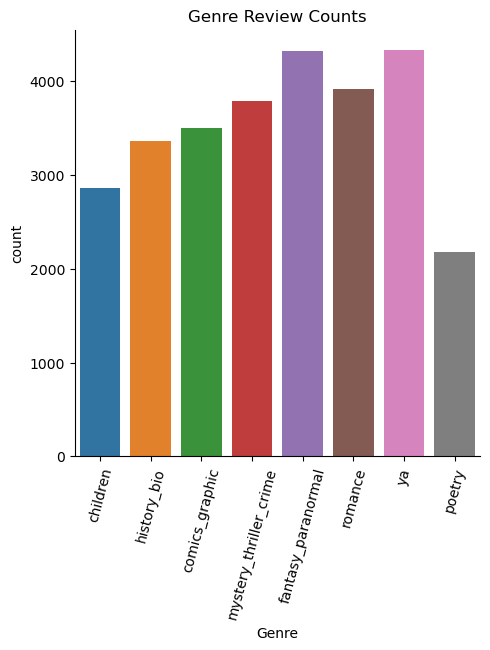

In [6]:
sns.catplot(x='Genre', kind='count', data=df)
plt.title('Genre Review Counts')
plt.xticks(rotation=75)

new_path = img_path + '/genre_counts.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Because nonsense text was a small issue when compiling the data, let's take a closer look at the composition of real vs. nonsense text across each genre.

In [7]:
nonsense_df = df.groupby('Genre').Nonsense.value_counts().unstack()

total = nonsense_df.nonsense + nonsense_df.real + nonsense_df.short
nonsense_df['total'] = total

nonsense_percent = nonsense_df.nonsense / nonsense_df.total
nonsense_df['nonsense_percent'] = nonsense_percent

short_percent = nonsense_df.short / nonsense_df.total
nonsense_df['short_percent'] = short_percent

nonsense_df

Nonsense,nonsense,real,short,total,nonsense_percent,short_percent
Genre,,,,,,
children,37,2785,36,2858,0.012946,0.012596
comics_graphic,68,3367,70,3505,0.019401,0.019971
fantasy_paranormal,107,4154,62,4323,0.024751,0.014342
history_bio,60,3267,35,3362,0.017847,0.010410
mystery_thriller_crime,65,3688,36,3789,0.017155,0.009501
poetry,50,2109,26,2185,0.022883,0.011899
romance,101,3739,78,3918,0.025778,0.019908
ya,147,4110,77,4334,0.033918,0.017766


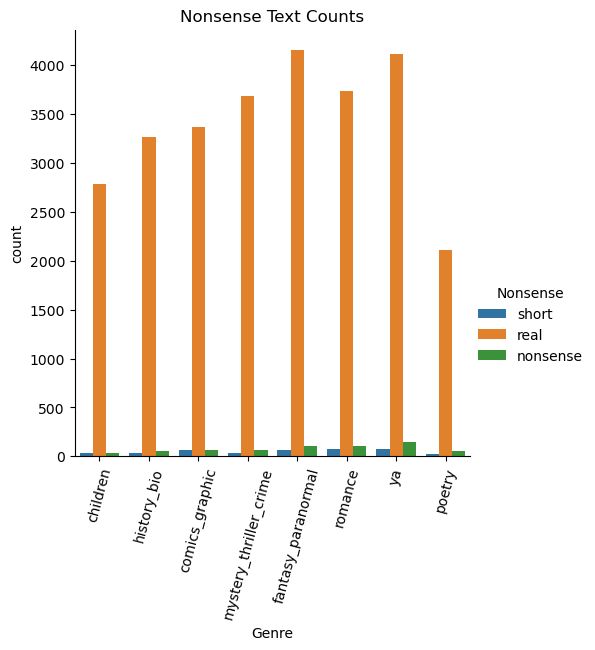

In [8]:
sns.catplot(x='Genre', hue='Nonsense', kind='count', data=df)
plt.title('Nonsense Text Counts')
plt.xticks(rotation=75)

new_path = img_path + '/nonsense_counts.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Luckily, it looks like a fairly even distribution of nonsense and short reviews. The percent of nonsense reviews in a genre ranges only from about 1.3% to 3.4%, which is not a large proportion. Hopefully this won't cause too much of an issue.

## Descriptive Stats by Genre

Lets find out which features are the most distinctive and have the most variation between genres!

In [9]:
#Creates list where I can add all features' ANOVA results to compare significance at once
significance_tests = []

### Rating

In [10]:
df.groupby('Genre').Rating.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,3.904829,1.203209,0.0,3.0,4.0,5.0,5.0
comics_graphic,3505.0,3.811412,1.153754,0.0,3.0,4.0,5.0,5.0
fantasy_paranormal,4323.0,3.816100,1.246819,0.0,3.0,4.0,5.0,5.0
history_bio,3362.0,3.851279,1.215740,0.0,3.0,4.0,5.0,5.0
mystery_thriller_crime,3789.0,3.727105,1.178367,0.0,3.0,4.0,5.0,5.0
poetry,2185.0,3.897941,1.276413,0.0,3.0,4.0,5.0,5.0
romance,3918.0,3.943849,1.212399,0.0,3.0,4.0,5.0,5.0
ya,4334.0,3.781034,1.272587,0.0,3.0,4.0,5.0,5.0


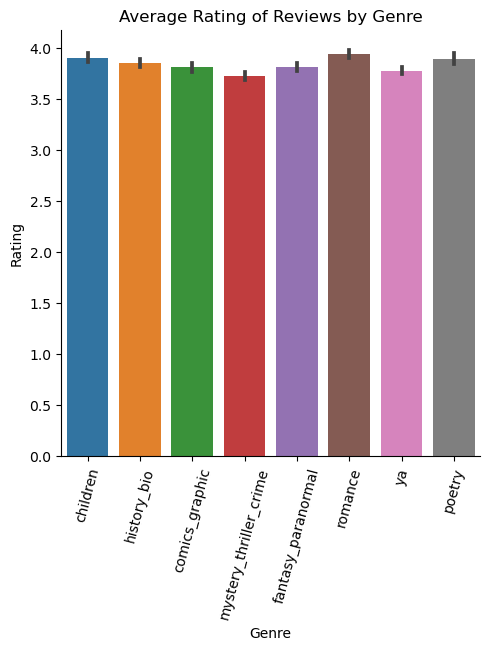

In [11]:
#Using a bar plot because box plot is the same for every genre
sns.catplot(data=df, x='Genre', y='Rating', kind='bar')
plt.title('Average Rating of Reviews by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/avg_rating_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

At first glance there doesn't appear to be a ton of variation. Each genre has the same 1st, 2nd, and 3rd quartile ratings of 3, 4, and 5 stars respectively, and the average doesn't show a ton of variation. However, the chart suggests that mystery/thriller/crime has slightly more negative reviews while romance has slightly more positive reviews, which makes sense given that romance is generally a more positive subject than crime.

In [12]:
#Checks if difference between genres is statistically significant
children_rating = df[(df.Genre == 'children')].Rating
hist_rating = df[(df.Genre == 'history_bio')].Rating
comics_rating = df[(df.Genre == 'comics_graphic')].Rating
mystery_rating = df[(df.Genre == 'mystery_thriller_crime')].Rating
fantasy_rating = df[(df.Genre == 'fantasy_paranormal')].Rating
romance_rating = df[(df.Genre == 'romance')].Rating
ya_rating = df[(df.Genre == 'ya')].Rating                    
poetry_rating = df[(df.Genre == 'poetry')].Rating

rating_test = stats.f_oneway(children_rating, hist_rating, comics_rating, mystery_rating, fantasy_rating, romance_rating, ya_rating, poetry_rating)
print(rating_test)

significance_tests.append(('Rating', rating_test))

F_onewayResult(statistic=12.486821345314613, pvalue=4.471076138185445e-16)


The F-value is about 12.49, meaning the variation in rating between genres is 12x the variation in rating within each genre group and has a significant p-value. This shows that the average rating is different across genres, but 12 isn't a very large F-value, so it's not the most telling feature.

### Ratings Count

(The number of reviews a book has on Goodreads)

In [13]:
df.groupby('Genre').Ratings_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,93980.546186,275095.225792,1.0,330.0,3001.5,31387.00,1876252.0
comics_graphic,3505.0,16528.807703,41517.096041,1.0,479.0,2705.0,12834.00,406669.0
fantasy_paranormal,4323.0,108879.451076,375846.839796,1.0,838.5,7755.0,55039.00,4765497.0
history_bio,3362.0,96545.556217,342835.065977,0.0,592.0,4165.0,30058.75,3255518.0
mystery_thriller_crime,3789.0,59168.214568,210601.102517,1.0,522.0,3984.0,22034.00,2046499.0
poetry,2185.0,44478.507551,151734.841123,0.0,148.0,1433.0,15270.00,1029527.0
romance,3918.0,32528.685299,143318.963490,1.0,333.0,1878.5,10393.00,2078406.0
ya,4334.0,211864.244347,652314.359248,1.0,2863.5,19151.0,106182.00,4899965.0


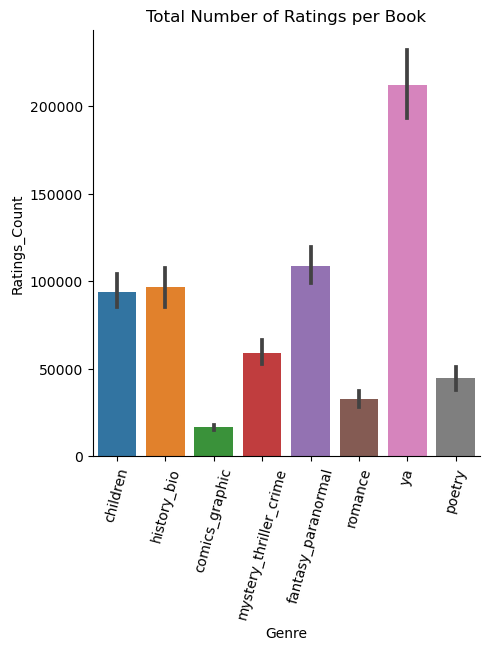

In [14]:
sns.catplot(data=df, x='Genre', y='Ratings_Count', kind='bar')
plt.title('Total Number of Ratings per Book')
plt.xticks(rotation=75)

new_path = img_path + '/ratings_count_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

When compared to the counts of reviews in my dataset for each genre vs. the overall number of reviews shown above, Romance and Children stand out as the most disproportionate. In my dataset, Romance is the 3rd-most reviewed genre, but overall had the 7th-most number of ratings out of all 8 genres. On the other hand, Children's Lit is the 7th-most reviewed genre in my dataset, but had the 4th-most number of ratings out of all 8 genres. Romance could be a genre to keep an eye on for further analysis - since its books have respectively few ratings but my dataset has a high frequency of reviews for that genre, it could indicate a very specific and dedicated reader-base made of few but active reviewers, their concentration suggesting more visible linguistic differences in their reviews.

### Token Count

In [15]:
df.groupby('Genre').Tok_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,90.446816,139.108835,1.0,19.0,45.0,101.00,2125.0
comics_graphic,3505.0,106.672183,160.568479,1.0,21.0,52.0,125.00,2877.0
fantasy_paranormal,4323.0,155.552625,216.315288,1.0,29.0,74.0,194.00,3803.0
history_bio,3362.0,147.559786,206.849123,1.0,31.0,75.0,177.00,2566.0
mystery_thriller_crime,3789.0,131.375033,184.020798,1.0,27.0,68.0,163.00,3924.0
poetry,2185.0,117.654005,218.564554,1.0,21.0,53.0,122.00,4159.0
romance,3918.0,161.168453,211.403155,1.0,30.0,80.0,209.75,2110.0
ya,4334.0,163.730964,231.898532,1.0,27.0,74.0,202.75,2840.0


As previously mentioned, this data tends to have large outliers that skew the data (as seen by the difference between the mean and 50% quartile). This makes box plots not very helpful (as shown below). 

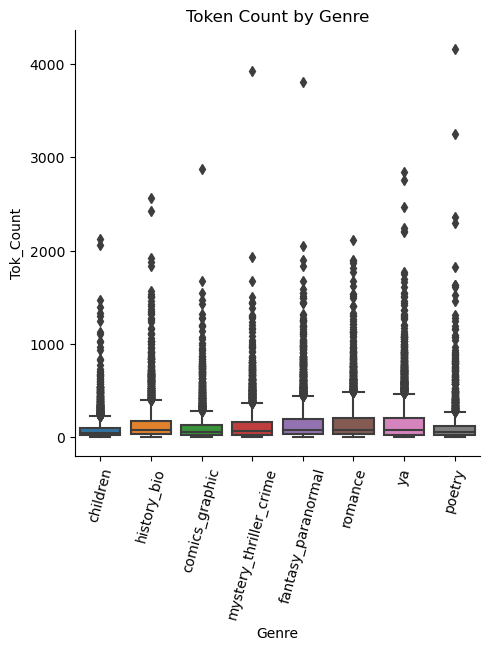

In [16]:
sns.catplot(data=df, x='Genre', y='Tok_Count', kind='box')
plt.title('Token Count by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/tok_count_box.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Therefore, from here on out, I will be using bar charts instead of box plots if the distribution is affected by these same circumstances of outliers. To mitigate the effect of said outliers, I will be using the median as my estimator instead of the mean.

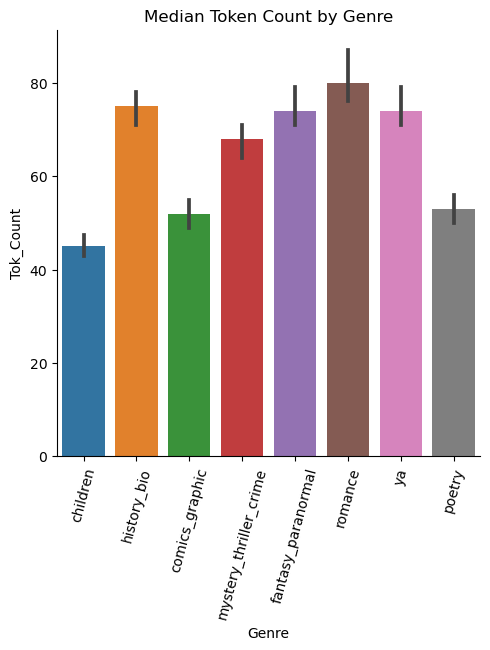

In [17]:
sns.catplot(data=df, x='Genre', y='Tok_Count', kind='bar', estimator=np.median)
plt.title('Median Token Count by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/tok_count_bar.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

This feature definitely appears to have some serious variation. Children's Literature, Comics/Graphic Novels, and Poetry seem to have the fewest tokens per review. This could be reflective of the text length as all of these genres likely involve shorter texts overall. This could reflect either just less content to discuss, leading to shorter reviews, or the shorter written reviews could reflect these readers' preferences for shorter texts in general.

In [18]:
#Checks if difference between genres is statistically significant

children_toks = df[(df.Genre == 'children')].Tok_Count
hist_tokts = df[(df.Genre == 'history_bio')].Tok_Count
comics_toks = df[(df.Genre == 'comics_graphic')].Tok_Count
mystery_toks = df[(df.Genre == 'mystery_thriller_crime')].Tok_Count
fantasy_toks = df[(df.Genre == 'fantasy_paranormal')].Tok_Count
romance_toks = df[(df.Genre == 'romance')].Tok_Count
ya_toks = df[(df.Genre == 'ya')].Tok_Count                    
poetry_toks = df[(df.Genre == 'poetry')].Tok_Count

toks_test = stats.f_oneway(children_toks, hist_tokts, comics_toks, mystery_toks, fantasy_toks, romance_toks, ya_toks, poetry_toks)
print(toks_test)

significance_tests.append(('Tok_Count', toks_test))

F_onewayResult(statistic=62.70663917469326, pvalue=5.454203218430883e-90)


The F-value is about 62.7, meaning the variation in rating between genres is 62x the variation in rating within each genre group, and it has a significant p-value (almost 0). This shows that the average rating is different across genres, and 62.7 is a much higher F-value, so token count is a distinctive feature across genres.

### Average Word Length

In [19]:
df.groupby('Genre').Avg_Word_Len.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2853.0,4.340696,0.730856,1.0,4.000000,4.285714,4.588235,11.5
comics_graphic,3474.0,4.386348,0.734120,1.0,4.036707,4.303751,4.609491,13.0
fantasy_paranormal,4302.0,4.264760,0.676670,1.0,3.968561,4.208661,4.461538,16.0
history_bio,3351.0,4.462218,0.752794,1.0,4.116614,4.382353,4.666667,16.0
mystery_thriller_crime,3774.0,4.365714,0.710656,1.0,4.035714,4.287096,4.585641,14.0
poetry,2174.0,4.451231,0.827943,1.0,4.048611,4.344400,4.684475,13.0
romance,3891.0,4.207006,0.613127,1.0,3.941284,4.160714,4.389480,16.0
ya,4299.0,4.234958,0.687662,1.0,3.947317,4.171334,4.428571,15.0


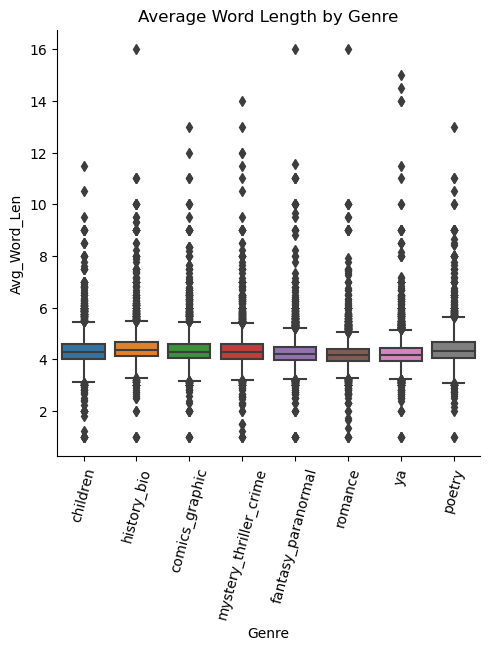

In [20]:
sns.catplot(data=df, x='Genre', y='Avg_Word_Len', kind='box')
plt.title('Average Word Length by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/word_len_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Reviews of History/Biography and Poetry books have the highest average word lengths (4.46 and 4.45 respectively). On the other hand, Romance and YA books have the lowest average word lenghts (4.21 and 4.23 respectively). Word length can be an indicator of vocabulary size as more advanced vocabulary is often longer in length. This could indicate a trend toward the vocabulary size of the readers of these genres, with readers of History/Biography and Poetry having a slightly more advanced vocabulary than readers of Romance/YA. However, given the small difference between the two groups, this is not a strong claim and would need more investigation.

In [21]:
df.Avg_Word_Len.info()

<class 'pandas.core.series.Series'>
RangeIndex: 28274 entries, 0 to 28273
Series name: Avg_Word_Len
Non-Null Count  Dtype  
--------------  -----  
28118 non-null  float64
dtypes: float64(1)
memory usage: 221.0 KB


On my first attempt to do the ANOVA test on word length, the results came up as NaN. Upon further investigation, this is because there are some null values in this column (see above). To address this, I will temporarily drop the rows with NaN values for the stats calculation only. 

In [22]:
#Checks if difference between genres is statistically significant

temp_df = df.dropna();

children_words = temp_df[(temp_df.Genre == 'children')].Avg_Word_Len
hist_words = temp_df[(temp_df.Genre == 'history_bio')].Avg_Word_Len
comics_words = temp_df[(temp_df.Genre == 'comics_graphic')].Avg_Word_Len
mystery_words = temp_df[(temp_df.Genre == 'mystery_thriller_crime')].Avg_Word_Len
fantasy_words = temp_df[(temp_df.Genre == 'fantasy_paranormal')].Avg_Word_Len
romance_words = temp_df[(temp_df.Genre == 'romance')].Avg_Word_Len
ya_words = temp_df[(temp_df.Genre == 'ya')].Avg_Word_Len                    
poetry_words = temp_df[(temp_df.Genre == 'poetry')].Avg_Word_Len

wordlen_test = stats.f_oneway(children_words, hist_words, comics_words, mystery_words, fantasy_words, romance_words, ya_words, poetry_words)
print(wordlen_test)

significance_tests.append(('Avg_Word_Len', wordlen_test))

F_onewayResult(statistic=62.5193645522048, pvalue=1.2661829262173734e-89)


The F-value is about 62.5, meaning the variation in rating between genres is 63x the variation in rating within each genre group, and it has a significant p-value. This shows that the average word length is different across genres, and 62.5 is a decently high F-value, so word length is a distinctive feature across genres.

### Average Number of Sentences

In [23]:
df.groupby('Genre').Sents_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,5.051784,6.312488,1.0,2.0,3.0,6.0,109.0
comics_graphic,3505.0,5.674750,7.257126,1.0,2.0,3.0,7.0,166.0
fantasy_paranormal,4323.0,8.613232,11.204685,1.0,2.0,5.0,10.0,179.0
history_bio,3362.0,7.389054,9.141050,1.0,2.0,4.0,9.0,89.0
mystery_thriller_crime,3789.0,7.115862,9.080802,1.0,2.0,4.0,9.0,174.0
poetry,2185.0,6.077346,10.417738,1.0,2.0,3.0,6.0,196.0
romance,3918.0,9.147269,11.045130,1.0,2.0,5.0,11.0,129.0
ya,4334.0,9.293263,12.855068,1.0,2.0,5.0,11.0,210.0


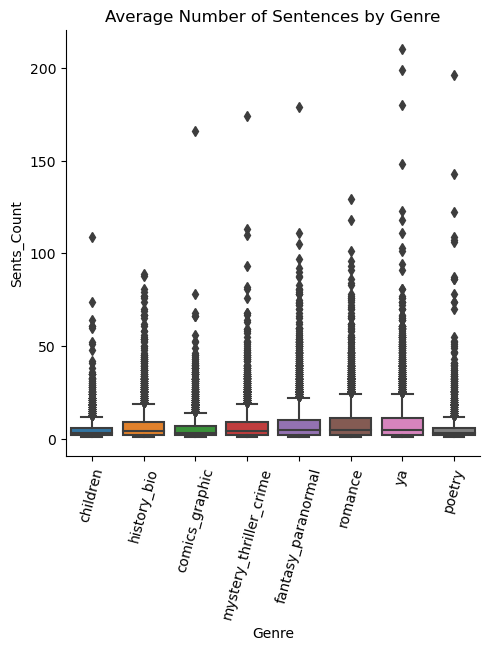

In [24]:
sns.catplot(data=df, x='Genre', y='Sents_Count', kind='box')
plt.title('Average Number of Sentences by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/sentence_count_box.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

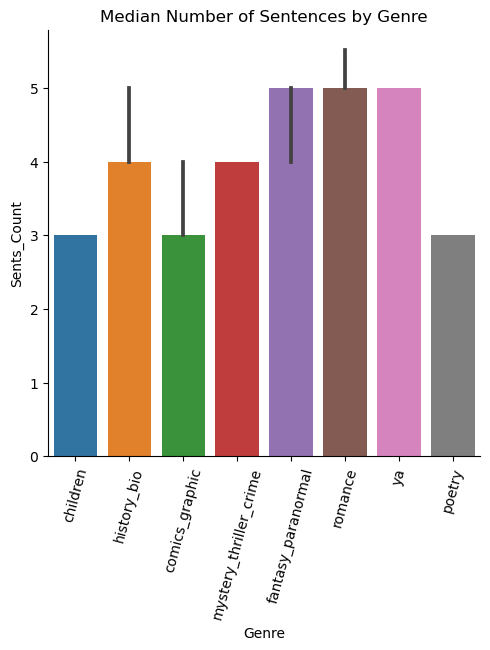

In [25]:
sns.catplot(data=df, x='Genre', y='Sents_Count', kind='bar', estimator=np.median)
plt.title('Median Number of Sentences by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/sentence_count_bar.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Similarly to token count, Children's Literature, Comics/Graphic Novels, and Poetry have the fewest number of sentences per review.

In [26]:
#Checks if difference between genres is statistically significant

children_sents = df[(df.Genre == 'children')].Sents_Count
hist_sents = df[(df.Genre == 'history_bio')].Sents_Count
comics_sents = df[(df.Genre == 'comics_graphic')].Sents_Count
mystery_sents = df[(df.Genre == 'mystery_thriller_crime')].Sents_Count
fantasy_sents = df[(df.Genre == 'fantasy_paranormal')].Sents_Count
romance_sents = df[(df.Genre == 'romance')].Sents_Count
ya_sents = df[(df.Genre == 'ya')].Sents_Count                    
poetry_sents = df[(df.Genre == 'poetry')].Sents_Count

sents_test = stats.f_oneway(children_sents, hist_sents, comics_sents, mystery_sents, fantasy_sents, romance_sents, ya_sents, poetry_sents)
print(sents_test)

significance_tests.append(('Sents_Count', sents_test))

F_onewayResult(statistic=89.83089407728102, pvalue=4.4958483393898035e-130)


The F-value is surprisingly high at about 89.93, meaning the variation in rating between genres is almost 90x the variation in rating within each genre group, and it has a significant p-value (almost 0). This shows that the number of sentences per review is different across genres, and that this is a very distinctive feature.

### Sentence Length

In [27]:
df.groupby('Genre').Avg_Sent_Len.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,15.537847,9.062199,1.0,10.000000,15.000000,19.770833,262.0
comics_graphic,3505.0,16.377889,9.950796,1.0,10.000000,15.666667,21.200000,258.0
fantasy_paranormal,4323.0,16.622772,11.694261,1.0,11.000000,15.666667,20.600000,388.0
history_bio,3362.0,18.155799,11.226322,1.0,12.333333,17.333333,22.500000,267.0
mystery_thriller_crime,3789.0,16.674117,8.788095,1.0,11.250000,15.900000,21.000000,150.0
poetry,2185.0,17.418711,11.402050,1.0,10.666667,16.000000,21.986486,173.0
romance,3918.0,16.011992,9.643031,1.0,10.500000,15.162281,20.000000,195.0
ya,4334.0,16.034264,9.668900,1.0,10.200000,15.170290,20.000000,205.0


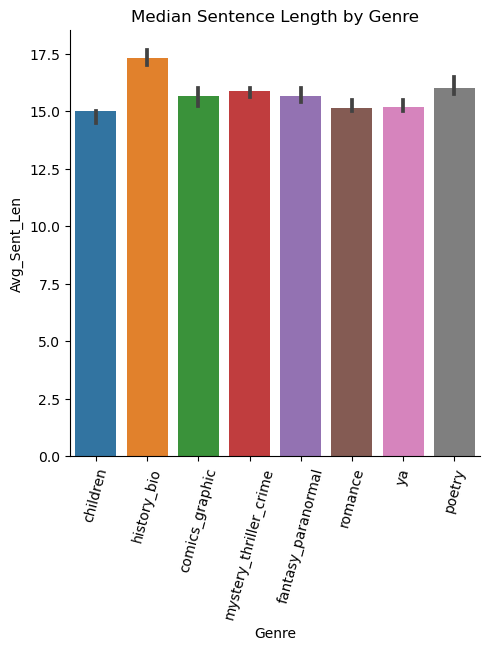

In [28]:
sns.catplot(data=df, x='Genre', y='Avg_Sent_Len', kind='bar', estimator=np.median)
plt.title('Median Sentence Length by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/sentence_len_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

There appears to be some decent variation in sentence length between reviews of different genres, which can be considered an indicator of syntactic complexity (longer sentences usually have more clauses/more complex syntax). Reviews of History/Biography books have the longest sentences, which is interesting because that is the only real nonfiction genre represented (though Mystery/Thriller/Crime could also include some nonfiction). This could indicate readers of nonfiction books use more syntactically complex sentences. On the other hand, Children's Lit, Romance, and YA books have shorter sentences in their reviews. Children and YA novels are intended for younger audiences, which could explain less syntactic complexity if the reviewers themselves are younger with less-developed language skills. However, the median sentence length across all genres only ranges from about 15-17 tokens, so any differences are likely not too significant.

In [29]:
#Checks if difference between genres is statistically significant

children_sents_len = df[(df.Genre == 'children')].Avg_Sent_Len
hist_sents_len = df[(df.Genre == 'history_bio')].Avg_Sent_Len
comics_sents_len = df[(df.Genre == 'comics_graphic')].Avg_Sent_Len
mystery_sents_len = df[(df.Genre == 'mystery_thriller_crime')].Avg_Sent_Len
fantasy_sents_len = df[(df.Genre == 'fantasy_paranormal')].Avg_Sent_Len
romance_sents_len = df[(df.Genre == 'romance')].Avg_Sent_Len
ya_sents_len = df[(df.Genre == 'ya')].Avg_Sent_Len                    
poetry_sents_len = df[(df.Genre == 'poetry')].Avg_Sent_Len

sentlen_test = stats.f_oneway(children_sents_len, hist_sents_len, comics_sents_len, mystery_sents_len, fantasy_sents_len, romance_sents_len, ya_sents_len, poetry_sents_len)
print(sentlen_test)

significance_tests.append(('Avg_Sent_Len', sentlen_test))


F_onewayResult(statistic=21.570377954827816, pvalue=3.031378324654984e-29)


The F-value is about 21.57, meaning the variation in rating between genres is about 22x the variation in rating within each genre group, and it has a significant p-value. This shows that the median sentence length is different across genres, but it's not the most significant feature.

### Average Sentiment (Numerical Value)
Just as a reminder, a positive number is more positive in sentiment while a negative number is more negative in sentiment (makes sense).

In [30]:
df.groupby('Genre').Sentiment_Num.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,0.312205,0.269940,-0.7268,0.126007,0.322476,0.507945,0.9784
comics_graphic,3505.0,0.234623,0.290222,-0.8951,0.006133,0.235900,0.439575,0.9780
fantasy_paranormal,4323.0,0.230441,0.258301,-0.8786,0.045948,0.222129,0.400612,0.9796
history_bio,3362.0,0.228653,0.277431,-0.9371,0.036689,0.221982,0.408325,0.9669
mystery_thriller_crime,3789.0,0.178113,0.280476,-0.9493,0.000000,0.165780,0.354567,0.9776
poetry,2185.0,0.242418,0.284537,-0.9078,0.025800,0.242675,0.426777,0.9827
romance,3918.0,0.260603,0.255257,-0.8074,0.087634,0.253128,0.430965,0.9801
ya,4334.0,0.216405,0.259816,-0.8897,0.025913,0.205384,0.376661,0.9903


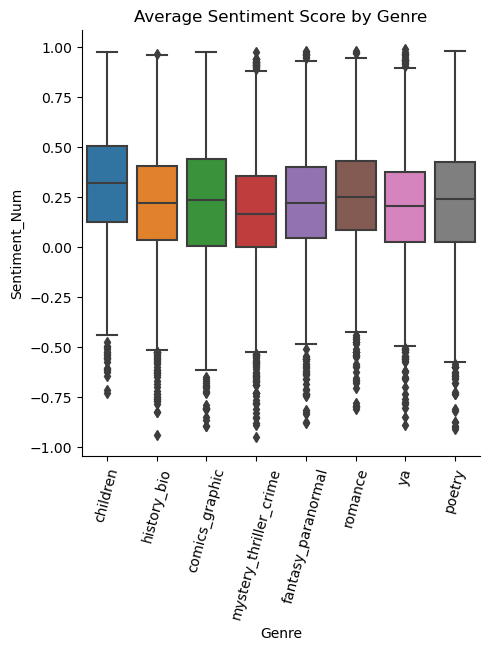

In [31]:
sns.catplot(x='Genre', y='Sentiment_Num', kind='box', data=df)
plt.title('Average Sentiment Score by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/sentiment_score.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Looking at this graph, it looks like Children's Literature is reviewed most positively (based on the text itself, not the rating) while Mystery/Thriller/Crime is reviewed most negatively (although still overall positive). This could be a result of the subject matter of the books being reviewed - children's books generally discuss happy topics while mystery and crime books generally discuss... well, not happy topics. If the reviews talk a lot about the content of the books, that could be what is making the difference in text-based sentiment.

In [32]:
#Checks if difference between genres is statistically significant

children_pos_num = df[(df.Genre == 'children')].Sentiment_Num
hist_pos_num = df[(df.Genre == 'history_bio')].Sentiment_Num
comics_pos_num = df[(df.Genre == 'comics_graphic')].Sentiment_Num
mystery_pos_num = df[(df.Genre == 'mystery_thriller_crime')].Sentiment_Num
fantasy_pos_num = df[(df.Genre == 'fantasy_paranormal')].Sentiment_Num
romance_pos_num = df[(df.Genre == 'romance')].Sentiment_Num
ya_pos_num = df[(df.Genre == 'ya')].Sentiment_Num                    
poetry_pos_num = df[(df.Genre == 'poetry')].Sentiment_Num

posnum_test = stats.f_oneway(children_pos_num, hist_pos_num, comics_pos_num, mystery_pos_num, fantasy_pos_num, romance_pos_num, ya_pos_num, poetry_pos_num)
print(posnum_test)

significance_tests.append(('Sentiment_Num', posnum_test))

F_onewayResult(statistic=65.66681131812767, pvalue=2.2733011670047155e-94)


The F-value is about 65.67, meaning the variation in rating between genres is about 66x the variation in rating within each genre group, and it has a significant p-value (near 0). This shows that the average sentiment number is different across genres and a fairly significant feature.

### Sentiment Tag (Positive/Negative/Neutral)

In [33]:
sentiment_df = df.groupby('Genre').Sentiment_Tag.value_counts().unstack()
sentiment_df

Sentiment_Tag,negative,neutral,positive
Genre,,,
children,282,174,2402
comics_graphic,572,291,2642
fantasy_paranormal,594,294,3435
history_bio,552,173,2637
mystery_thriller_crime,831,207,2751
poetry,293,210,1682
romance,425,239,3254
ya,640,313,3381


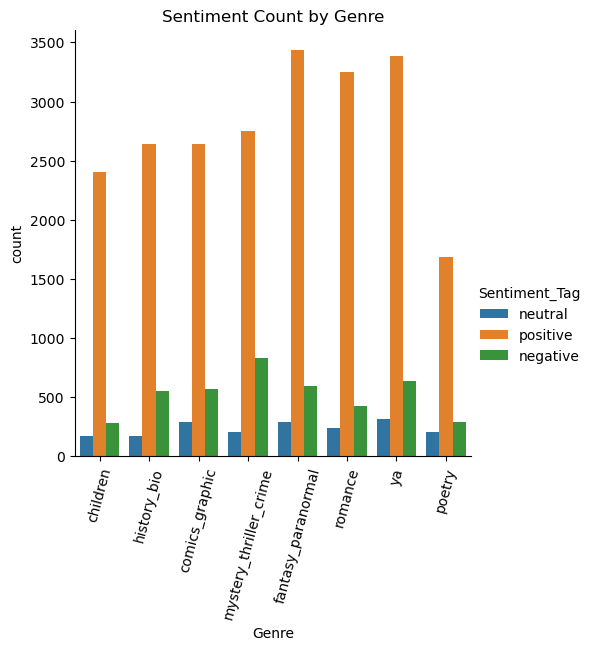

In [34]:
#Makes a different kind of bar plot comparing 3 categories across 8 genres
sns.catplot(x='Genre', hue='Sentiment_Tag', kind='count', data=df)
plt.title('Sentiment Count by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/sentiment_tag_counts.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

As shown by the last graph, Myster/Thriller/Crime books once again have the most negative reviews, followed by YA books. All genres have the same pattern of most positive reviews, then negative, then neutral. Children's Literature and Poetry seem to have the closest number of negative vs. neutral reviews, whereas the others have significantly more negative reviews than neutral. However, I want to adjust these for percentages rather than just counts because each genre does not have an even sample size of reviews, so let's take a look at that.

In [35]:
#Create function that takes in sentiment tag and returns percent with that tag for all genres
def get_percents(tag):
    percents = []
    for i in range (0, 8):
        sum = sentiment_df.iloc[i].sum()
        percent = sentiment_df[tag].iloc[i]/sum
        percents.append(percent)
    return percents
get_percents('negative') #test with negative tag, it works!

[0.0986703988803359,
 0.1631954350927247,
 0.13740458015267176,
 0.16418798334324808,
 0.21931908155186064,
 0.13409610983981693,
 0.10847371107708015,
 0.14766958929395477]

In [36]:
#add percents for all 3 tags to sentiment dataframe
sentiment_df['%negative'] = get_percents('negative')
sentiment_df['%neutral'] = get_percents('neutral')
sentiment_df['%positive'] = get_percents('positive')
sentiment_df

Sentiment_Tag,negative,neutral,positive,%negative,%neutral,%positive
Genre,,,,,,
children,282,174,2402,0.098670,0.060880,0.840401
comics_graphic,572,291,2642,0.163195,0.083020,0.753727
fantasy_paranormal,594,294,3435,0.137405,0.068006,0.794549
history_bio,552,173,2637,0.164188,0.051455,0.784304
mystery_thriller_crime,831,207,2751,0.219319,0.054629,0.725997
poetry,293,210,1682,0.134096,0.096104,0.769713
romance,425,239,3254,0.108474,0.060999,0.830490
ya,640,313,3381,0.147670,0.072217,0.780071


Looking at the percents, Mystery/Thriller/Crime does still have the highest percentage of negative reviews. Children's Literature has the highest percentage of positive reviews, followed closely by Romance.

### Adjectives Count

In [37]:
df.groupby('Genre').Adjs_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,6.622113,9.609525,0.0,2.0,4.0,8.0,113.0
comics_graphic,3505.0,8.227960,11.556355,0.0,2.0,4.0,10.0,179.0
fantasy_paranormal,4323.0,10.806384,14.986628,0.0,2.0,5.0,14.0,309.0
history_bio,3362.0,10.582689,14.500526,0.0,2.0,6.0,13.0,182.0
mystery_thriller_crime,3789.0,9.166007,12.084713,0.0,2.0,5.0,12.0,202.0
poetry,2185.0,8.104805,14.118724,0.0,1.0,4.0,9.0,253.0
romance,3918.0,10.698060,13.800133,0.0,2.0,6.0,14.0,149.0
ya,4334.0,11.027457,15.495283,0.0,2.0,5.0,14.0,202.0


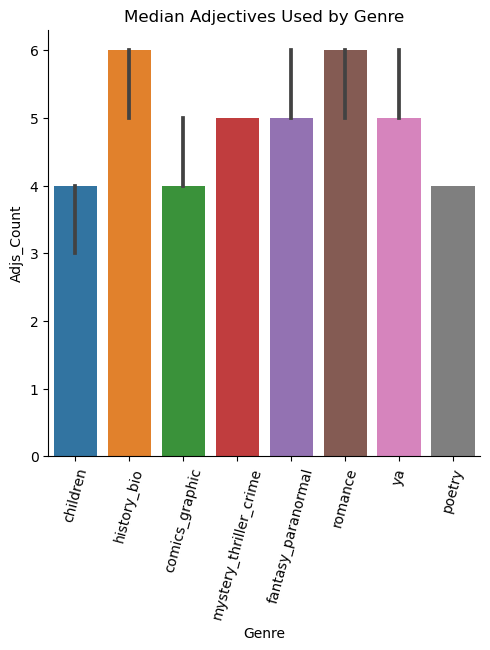

In [38]:
sns.catplot(x='Genre', y='Adjs_Count', kind='bar', estimator=np.median, data=df)
plt.title('Median Adjectives Used by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/adjs_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

There seems to be decent variation between genres in the median number of adjectives used. Surprisingly, poetry (along with children's literature and compics/graphic novels) is the lowest at 4 adjectives per review - I would have expected readers of poetry, which is usually quite descriptive, to use more adjectives. It's also interesting that history/biography reviews use a higher number of adjectives - a median of 6. I wouldn't have expected this genre to be descriptive in the same way as poetry or maybe fantasy, but this could be another indicator of more advanced vocabulary usage for the reviews of nonfiction.

In [39]:
#Checks if difference between genres is statistically significant

children_adjs = df[(df.Genre == 'children')].Adjs_Count
hist_adjs = df[(df.Genre == 'history_bio')].Adjs_Count
comics_adjs = df[(df.Genre == 'comics_graphic')].Adjs_Count
mystery_adjs = df[(df.Genre == 'mystery_thriller_crime')].Adjs_Count
fantasy_adjs = df[(df.Genre == 'fantasy_paranormal')].Adjs_Count
romance_adjs = df[(df.Genre == 'romance')].Adjs_Count
ya_adjs = df[(df.Genre == 'ya')].Adjs_Count                    
poetry_adjs = df[(df.Genre == 'poetry')].Adjs_Count

adjs_test = stats.f_oneway(children_adjs, hist_adjs, comics_adjs, mystery_adjs, fantasy_adjs, romance_adjs, ya_adjs, poetry_adjs)
print(adjs_test)

significance_tests.append(('Adjs_Count', adjs_test))

F_onewayResult(statistic=47.21259519012014, pvalue=4.6723472388855024e-67)


The F-value is about 47.21, meaning the variation in rating between genres is about 47x the variation in rating within each genre group, and it has a significant p-value. This shows that the average number of adjectives used is different across genres and a fairly significant feature.

In the future I would also like to look at which adjectives are most commonly used across each genre to see if there is any variation in vocabulary.

### K-Bands

In [40]:
df.groupby('Genre').Avg_K.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2848.0,2.335231,1.177319,1.0,1.725436,2.105263,2.588717,16.0
comics_graphic,3452.0,2.395824,1.249540,1.0,1.818182,2.155700,2.583333,18.0
fantasy_paranormal,4281.0,2.240519,0.958037,1.0,1.785714,2.100423,2.444444,14.0
history_bio,3338.0,2.336216,1.045876,1.0,1.846154,2.167603,2.555556,18.0
mystery_thriller_crime,3764.0,2.381200,1.222478,1.0,1.841756,2.184429,2.592593,20.0
poetry,2161.0,2.512122,1.403854,1.0,1.831683,2.226190,2.714286,20.0
romance,3875.0,2.266346,0.982354,1.0,1.818927,2.123457,2.459707,14.5
ya,4275.0,2.242961,1.022720,1.0,1.766450,2.069182,2.426296,20.0


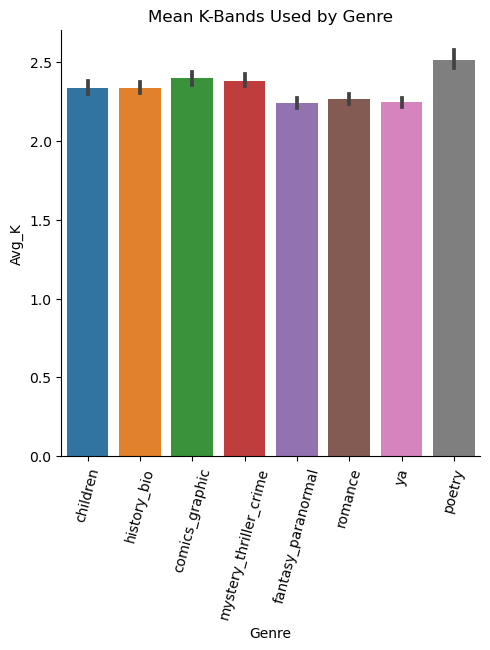

In [41]:
sns.catplot(x='Genre', y='Avg_K', kind='bar', data=df)
plt.title('Mean K-Bands Used by Genre')
plt.xticks(rotation=75)

new_path = img_path + '/mean_kband_per_genre.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

There isn't a ton of variation in the average k-band of the vocabulary used in each genre's reiews, but poetry seems to be the one (small) outlier. While the other genres have average k-bands of in the 2.2s and 2.3s, the average k-band of the poetry reviews is 2.51. This is super interesting because I would imagine poetry uses a lot more specific, maybe obscure vocabulary, so it's fascinating that the reviews of poetry reflect that more unique vocabulary usage as well.

In [42]:
df.Avg_K.info()

<class 'pandas.core.series.Series'>
RangeIndex: 28274 entries, 0 to 28273
Series name: Avg_K
Non-Null Count  Dtype  
--------------  -----  
27994 non-null  float64
dtypes: float64(1)
memory usage: 221.0 KB


Like the average word length, this column does have some null values, so I'll have to drop those temporarily to do the statistical test.

In [43]:
#Checks if difference between genres is statistically significant
temp_df = df.dropna() #drops NaN values temporarily to compute t-test

children_k = temp_df[(temp_df.Genre == 'children')].Avg_K
hist_k = temp_df[(temp_df.Genre == 'history_bio')].Avg_K
comics_k = temp_df[(temp_df.Genre == 'comics_graphic')].Avg_K
mystery_k = temp_df[(temp_df.Genre == 'mystery_thriller_crime')].Avg_K
fantasy_k = temp_df[(temp_df.Genre == 'fantasy_paranormal')].Avg_K
romance_k = temp_df[(temp_df.Genre == 'romance')].Avg_K
ya_k = temp_df[(temp_df.Genre == 'ya')].Avg_K                    
poetry_k = temp_df[(temp_df.Genre == 'poetry')].Avg_K

kband_test = stats.f_oneway(children_k, hist_k, comics_k, mystery_k, fantasy_k, romance_k, ya_k, poetry_k)
print(kband_test)

significance_tests.append(('Avg_Kband', kband_test))

F_onewayResult(statistic=17.20719359478615, pvalue=7.047058084756164e-23)


## Statistics Recap

In [44]:
for (feature, stats) in significance_tests:
    print(feature + ":\n" + str(stats) + "\n")

Rating:
F_onewayResult(statistic=12.486821345314613, pvalue=4.471076138185445e-16)

Tok_Count:
F_onewayResult(statistic=62.70663917469326, pvalue=5.454203218430883e-90)

Avg_Word_Len:
F_onewayResult(statistic=62.5193645522048, pvalue=1.2661829262173734e-89)

Sents_Count:
F_onewayResult(statistic=89.83089407728102, pvalue=4.4958483393898035e-130)

Avg_Sent_Len:
F_onewayResult(statistic=21.570377954827816, pvalue=3.031378324654984e-29)

Sentiment_Num:
F_onewayResult(statistic=65.66681131812767, pvalue=2.2733011670047155e-94)

Adjs_Count:
F_onewayResult(statistic=47.21259519012014, pvalue=4.6723472388855024e-67)

Avg_Kband:
F_onewayResult(statistic=17.20719359478615, pvalue=7.047058084756164e-23)



## Machine Learning

I am going to try using machine learning to see just how significant the differences between genres' reviews and their language really is - if a classifer can determine what genre a review is talking about based on its text or other features, that's an indicator that the language used is significantly different.

### Numerical Features (K Nearest Neighbors)

Here I'm building a K-Nearest Neighbors classifier based on numerical features from above. I'm starting with just the most statistically significant categories in case some of the less significant categories are actually detrimental to the classifier's performance. 

In [45]:
import sklearn
from sklearn.model_selection import train_test_split

X = df[['Sents_Count', 'Sentiment_Num', 'Tok_Count']] #F-scores above 60, excludes word length because of NaN values
y = df['Genre'] #Labels are genres

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [46]:
from sklearn.neighbors import KNeighborsClassifier
k_clf = KNeighborsClassifier(n_neighbors = 56) #Best number of neighbors after testing with 2-100 neighbors
k_clf.fit(X_train, y_train)

y_pred = k_clf.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)

0.15632183908045977

Yike's, that's barely better than just a random 1/8 chance (0.125). Let's see if using all numerical features (minus word length and k-band for their null values), helps improve the performance.

In [47]:
#All numerical features
X2 = df[['Sents_Count', 'Sentiment_Num', 'Tok_Count', 'Adjs_Count', 'Avg_Sent_Len', 'Rating']]
y2 = df['Genre']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 5)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
k_clf2 = KNeighborsClassifier(n_neighbors = 36) 
k_clf2.fit(X2_train, y2_train)
y2_pred = k_clf2.predict(X2_test)
sklearn.metrics.accuracy_score(y2_test, y2_pred)

0.15225464190981433

And that's worse. So clearly, even though the ANOVA tests show that the difference between the numerical features of each genre's reviews are significant, they're not that distinctive since the classifier can't make many accurate predictions based on that data. Let's try a classifier with the text directly.

### Review Text TF IDF

This is a Multinomial Naive-Bayes classifier built on the entire review text. In my first attempts at creating this classifier, regardless of how I adjusted the parameters, some words showed up repeatedly in almost every category as a significant feature. Therefore, I made my own custom list of stop words with some of those words to try and remove them from the equation. 

In [49]:
from sklearn.feature_extraction import text 

new_stop = ['really', 'like', 'love', 'read', 'book', 'story'] #common words in this specific
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(new_stop)) #combines with existing english stopwords list

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_train, text_test, y_train, y_test = train_test_split(df.Text, df.Genre, test_size = 0.2, random_state = 8)

tvzer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range = (1, 2), min_df = 2) 
#adding max_df, custom stop words decreased performance (stuck with just english stopwords) 
#increasing features to 10000 and adding bigrams improved performance

train_tfidf = tvzer.fit_transform(text_train)  
test_tfidf = tvzer.transform(text_test) 

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb_clf = MultinomialNB()
mnb_clf.fit(train_tfidf, y_train)
MultinomialNB()

y_pred_mnb = mnb_clf.predict(test_tfidf)
accuracy_score(y_test, y_pred_mnb)

0.5073386383731211

Much better than the numerical features!!! 50% isn't anything crazy, but it's definitely a big step up from before.

(Function below adapted from Na-Rae's code found [here](https://github.com/Data-Science-for-Linguists-2023/Class-Exercise-Repo/blob/main/activity6_ml/Machine_Learning_intro2.ipynb))

In [52]:
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.feature_log_prob_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '_') for j in top)))
             # ^ comma-separate                      ^^^ use _ for n-grams if any 
        print()
                
print_top(tvzer, mnb_clf, mnb_clf.classes_, 15)  

children: good, like, loved, little, great, fun, love, kids, cute, books, illustrations, children, story, read, book

comics_graphic: love, just, great, book, comic, good, graphic_novel, like, really, series, read, art, graphic, story, volume

fantasy_paranormal: reading, great, world, loved, books, good, characters, love, really, like, just, story, read, series, book

history_bio: characters, historical, loved, history, just, love, time, good, really, life, great, like, story, read, book

mystery_thriller_crime: novel, reading, love, great, books, really, just, like, characters, series, good, mystery, story, read, book

poetry: life, time, just, reading, really, words, beautiful, like, poem, love, collection, read, book, poetry, poems

romance: review, books, romance, stars, good, characters, like, really, series, just, loved, story, read, love, book

ya: didn, books, reading, stars, characters, series, good, loved, story, love, just, like, really, read, book



Here you can see some of the stop words I tried to get rid of: like, really, book, good, etc., but it didn't really helpf the classifier. There are definitely some content specific words in here: "comic", "graphic_novel", and "art" for comics and graphic novels, "historical" and "history" for history and bigraphies, and "beautiful", "poem", and "poetry" for poetry.

### Adjective Only TF IDF
As I began working through the data, I had the idea that adjectives in particular might be indicative of different genre reviews. After all, readers probably would use different adjectives to describe a romance novel than a history book or graphic novel. The number of adjectives used wasn't super significant, so here I'm going to try making a Multinomial Naive Bayes classifier based only on the adjectives from each review.

In [53]:
#Again made custom stop word list after first attempt
adj_stop = ['little', 'best', 'good', 'great']
my_stop_adjs = list(text.ENGLISH_STOP_WORDS.union(adj_stop))

In [54]:
adj_train, adj_test, y_train, y_test = train_test_split(df.Adjs, df.Genre, test_size = 0.2, random_state = 7)

adj_tvzer = TfidfVectorizer(max_features=1000, stop_words=my_stop_adjs)
#1000 features best performance

adj_train_tfidf = adj_tvzer.fit_transform(adj_train)  
adj_test_tfidf = adj_tvzer.transform(adj_test) 

adj_clf = MultinomialNB()
adj_clf.fit(adj_train_tfidf, y_train)
MultinomialNB()

y_pred_adj = adj_clf.predict(adj_test_tfidf)
accuracy_score(y_test, y_pred_adj)

0.31618037135278515

So the adjective-based classifier did better than the numerical features, but not as good as the classifier based on the whole text. I guess that's not super surprising as more data is almost always helpful, but let's take a look at the most significant adjective features for each genre to see if there are any patterns to note.

In [55]:
print_top(adj_tvzer, adj_clf, adj_clf.classes_, 20)

children: real, adorable, better, perfect, simple, sweet, interesting, lovely, middle, fun, nice, different, new, wonderful, funny, beautiful, favorite, young, old, cute

comics_graphic: cool, original, favorite, big, fun, short, sure, awesome, funny, nice, bad, beautiful, cute, different, better, amazing, new, interesting, comic, graphic

fantasy_paranormal: long, fun, wonderful, strong, real, hard, happy, nice, sure, awesome, favorite, second, short, bad, different, main, better, amazing, new, interesting

history_bio: old, sure, worth, favorite, enjoyable, hard, better, excellent, amazing, long, true, new, real, fascinating, beautiful, young, wonderful, different, historical, interesting

mystery_thriller_crime: short, fun, dark, quick, amazing, easy, second, old, real, favorite, bad, hard, excellent, enjoyable, different, sure, better, new, main, interesting

poetry: free, worth, better, young, old, long, poetic, powerful, personal, new, lovely, simple, interesting, amazing, sure, 

Definitely some interesting adjectives in here! Here are the adjectives that stood out to me:

Children's Literature: adorable, simple, sweet, young

Comics/Graphic Novels: short, cute, comic, graphic

Fantasy/Paranormal: long, strong

History/Biography: hard, true, real, historical

Mystery/Thriller/Crime: short, dark

Poetry: free, long, poetic, powerful, personal, beautiful

Romance: sexy, sweet, hot

Young Adult: short, happy

### Clustering

Code adapted from Na-Rae Han tutorial found [here](https://github.com/Data-Science-for-Linguists-2023/Class-Exercise-Repo/blob/main/activity7_crc/clustering.ipynb)

I was curious to see if the classifier would pick up on any of the genres based on the vocabulary used, so I tried creating a clustering model and gave it 8 topics (the number of genres) to see what it would come up with and if any vocabulary words were strongly associated with a specific genre or with other words.

In [56]:
from sklearn.pipeline import Pipeline

tfidf_model = TfidfVectorizer(max_features=20000, min_df=2, max_df=0.3, stop_words='english')

x = df['Text']
y = df['Genre']

x_tfidf = tfidf_model.fit_transform(x, y)

In [57]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=8)         
x_svd = svd_model.fit_transform(x_tfidf,y)

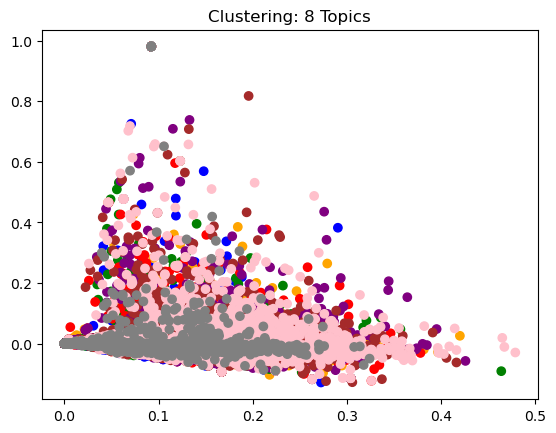

In [58]:
cdict = {'children':'blue', 'history_bio':'orange', 'comics_graphic':'green', 'mystery_thriller_crime':'red',
        'fantasy_paranormal':'purple', 'romance':'brown', 'ya':'pink', 'poetry':'gray'}
colors = y.map(cdict)

plt.scatter(x_svd[:, 0], x_svd[:, 1], c=colors) 
plt.title('Clustering: 8 Topics')

new_path = img_path + '/clustering.png'
plt.savefig(new_path, bbox_inches='tight', pad_inches=0.25)

plt.show()

Yikes, there are definitely not very many visible clusters in here - it's just one big cluster. Poetry seems to be a bit more condensed, so maybe some poetry-related words will show up in the significant features for one of the topics the model found? Let's look.

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# custom function for print out topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

documents = df.Text
num_feats = 1000
num_tops = 8

tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, max_features=num_feats, stop_words='english')
tfidf_docs = tfidf_vect.fit_transform(documents)

nmf_model = NMF(n_components=num_tops, random_state=1, l1_ratio=.5, 
                init='nndsvd').fit(tfidf_docs)

display_topics(nmf_model, tfidf_vect.get_feature_names_out(), 25)

Topic 0:
like just really story characters didn time did don way know think reading little life character end liked things world people lot going felt feel
Topic 1:
love books heart beautiful romance story fall amazing poems just absolutely wait wonderful fell want awesome poetry hate life perfect sweet way relationship words oh
Topic 2:
read books fun ve quick wait easy reading best time cute definitely enjoyed enjoyable poetry amazing review recommend worth day want haven written movie fast
Topic 3:
loved wait absolutely amazing characters story ending beautiful heart perfect fantastic end couldn hot wonderful sweet really happy awesome hilarious cute seeing recommend definitely funny
Topic 4:
stars review rating come actual half gave http giving liked ending amazing given com solid better blog overall star cute second didn 10 hell definitely
Topic 5:
series books favorite wait characters far reading best enjoyed better new forward volume ending rest mystery second looking start cont

/Users/ashleyfeiler/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


While most of these don't really indicate a specific genre, topics 1, 6, and 7 do seem to point toward specific genres. Topic 1 was defined by words such as "heart", "romance", "beautiful", "relationship", and "poems", which could point to either the Romance or Poetry genres. This would fit my prediction based on the cluster map above that poetry would appear as a topic! Additionally, Topic 6 has words like "illustrations", "art", "history", and "graphic", which is a bit all over the place but I can see either being Children's Literature or Comics/Graphic Novels. Finally, Topic 7 included the words "mystery", "plot", "twist", and "predictable, which could point toward the Mystery/Thriller/Crime genre (mysteries often have twist endings).

## Summary

### Numerical Features

**Rating:**
Mystery/Thriller/Crime has slightly more negative ratings while Romance has slightly more positive ratings (romance content is more positive than mystery/thriller/crime).

**Token Count:**
Children's Literature, Comics/Graphic Novels, and Poetry have the fewest median tokens per review (likely related to length of book being reviewed - shorter book = shorter review or readers prefer shorter texts). Romance and History/Biography have the highest median tokens per review.

**Word Length:**
History/Biography and Poetry reviews have the highest average word length. Romance and YA reviews have the lowest average word length. (Could suggest  readers of History/Biography and Poetry having a slightly more advanced vocabulary than readers of Romance/YA).

**Sentence Count:**
Children's Literature, Comics/Graphic Novels, and Poetry have the fewest sentences per review (same three as lowest token count).

**Sentence Length:**
History/Biography book reviews have the longest sentences (suggests readers of nonfiction books use more syntactically complex sentences).

**Sentiment:**
Children's Literature reviews are the most positive (based on the text) while Mystery/Thriller/Crime are the most negative (likely reflects sentiment of subject matter of the books being reviewed rather than the reviewer's opinion). 

**Adjectives:**
Poetry and Children's Literature have the lowest median number of adjectives per review (4). History/Biography and Romances have the highest median number of adjectives per review (6). 

**K-Bands:** 
Poetry reviews have a slightly higher average k-band per review than the other genres (could indicate poetry readers have more advanced vocabulary). 

### Machine Learning

**Numerical Features:**
While individual differences are of note, overall they make for a poor-performing classifier. 

**TF-IDF (Naive Bayes):**
The entire review text trained the most accurate classifier at about 50% accuracy. Training a classifier on adjectives alone was more accurate than the numerical features, but not as accurate as using the whole text. 

**Clustering:**
Poetry & Romance, Children's Literature & Graphic Novels, and Mystery/Thriller/Crime novels have the most distinct vocabulary (genres reflected by clustering).